In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import pandas as pd
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Importar o modelo contrastivo desenvolvido anteriormente

In [3]:
# fiz sem o bidirectional, não sei se é necessário para o meu teste simples 
class SMILESEncoder(torch.nn.Module):
    def __init__(self, vocab_size, max_len, padding_idx, embedding_dim=64, dim=128, num_layers=1):
        super(SMILESEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.embedding_dim = embedding_dim
        self.dim = dim
        self.num_layers = num_layers

        self.encoder = torch.nn.LSTM(self.embedding_dim, self.dim, self.num_layers, batch_first=True)

    def forward(self, x, lengths):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        valid_lengths = torch.clamp(lengths, min=1, max=seq_len)
        
        # Mover lengths para a CPU antes de empacotar
        lengths_on_cpu = valid_lengths.cpu()
        
        x_packed = rnn_utils.pack_padded_sequence(
            x, lengths=lengths_on_cpu, batch_first=True, enforce_sorted=False
        )

        _, (hidden, _) = self.encoder(x_packed)
        return hidden[-1]
    
class CLRNet(torch.nn.Module):
    def __init__(self, vocab_size, max_len, padding_idx, embedding_dim=64, dim=128, num_layers=1):
        super(CLRNet, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.embedding_dim = embedding_dim
        self.dim = dim
        self.num_layers = num_layers

        self.emb = torch.nn.Embedding(
            num_embeddings=self.vocab_size, 
            padding_idx=self.padding_idx,
            embedding_dim=self.embedding_dim, 
        )

        # definindo as duas redes LSTM responsáveis pelo aprendizado contrastivo
        self.SMILESEnc1 = SMILESEncoder(vocab_size=self.vocab_size, max_len=self.max_len, padding_idx=self.padding_idx,
                                        embedding_dim=self.embedding_dim, dim=2*self.dim, num_layers=self.num_layers)
        

        self.SMILESEnc2 = SMILESEncoder(vocab_size=self.vocab_size, max_len=self.max_len, padding_idx=self.padding_idx,
                                        embedding_dim=self.embedding_dim, dim=2*self.dim, num_layers=self.num_layers)
        
        # cabeça de projeção MLP
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(2*self.dim, 4 * self.dim),
            torch.nn.BatchNorm1d(4 * self.dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4*self.dim, 6*self.dim, bias=False)
        )
    
    def forward(self, smi, random_smi, smi_len, random_smi_len):
        x = self.emb(smi)
        
        x1 = self.emb(random_smi)
        
        enc1 = self.SMILESEnc1(x, smi_len)
        enc2 = self.SMILESEnc2(x1, random_smi_len)
        
        return F.normalize(self.projection_head(enc1), dim=1), F.normalize(self.projection_head(enc2), dim=1)

In [4]:
clr_model = CLRNet(vocab_size=82, max_len=24, padding_idx=81)
clr_model.load_state_dict(torch.load("clr_model.pth"))
clr_model.to(device)

CLRNet(
  (emb): Embedding(82, 64, padding_idx=81)
  (SMILESEnc1): SMILESEncoder(
    (encoder): LSTM(64, 256, batch_first=True)
  )
  (SMILESEnc2): SMILESEncoder(
    (encoder): LSTM(64, 256, batch_first=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=768, bias=False)
  )
)

In [5]:
smi_encoder = SMILESEncoder(vocab_size=82, max_len=24, padding_idx=81)

# Definindo os dados

In [6]:
qm9 = pd.read_csv("../supervised-learning/QM9.csv", index_col=0)
qm9

,SMILES_1,SMILES_2,INCHI_1,INCHI_2,Property_0
0,OC1COC(=N)C1=O,O[C@H]1CO[C]([NH])C1=O,"InChI=1S/C4H5NO3/c5-4-3(7)2(6)1-8-4/h2,5-6H,1H2","InChI=1S/C4H5NO3/c5-4-3(7)2(6)1-8-4/h2,5-6H,1H...",3.49649
1,CN(C)C(=O)C=O,CN(C)C(=O)C=O,"InChI=1S/C4H7NO2/c1-5(2)4(7)3-6/h3H,1-2H3","InChI=1S/C4H7NO2/c1-5(2)4(7)3-6/h3H,1-2H3",3.92544
2,C1C2CC3N=COCC123,C1[C@H]2C[C@@H]3N=COC[C@]123,InChI=1S/C7H9NO/c1-5-2-7(5)3-9-4-8-6(1)7/h4-6H...,InChI=1S/C7H9NO/c1-5-2-7(5)3-9-4-8-6(1)7/h4-6H...,3.02103
3,OC1C2OC3CC2C13O,O[C@H]1[C@H]2O[C@@H]3C[C@H]2[C@]13O,"InChI=1S/C6H8O3/c7-5-4-2-1-3(9-4)6(2,5)8/h2-5,...","InChI=1S/C6H8O3/c7-5-4-2-1-3(9-4)6(2,5)8/h2-5,...",2.52006
4,OC1C2C(=N)OCC12O,O[C@H]1[C@H]2[C]([NH])OC[C@@]12O,"InChI=1S/C5H7NO3/c6-4-2-3(7)5(2,8)1-9-4/h2-3,6...","InChI=1S/C5H7NO3/c6-4-2-3(7)5(2,8)1-9-4/h2-3,6...",2.48587
...,...,...,...,...,...
133880,CC1=C(N)C(=NN1)C#C,Cc1c(N)c(n[nH]1)C#C,"InChI=1S/C6H7N3/c1-3-5-6(7)4(2)8-9-5/h1H,7H2,2...","InChI=1S/C6H7N3/c1-3-5-6(7)4(2)8-9-5/h1H,7H2,2...",3.37027
133881,CC(C)(C)C(O)C(N)=O,CC(C)(C)[C@@H](O)C(=O)N,"InChI=1S/C6H13NO2/c1-6(2,3)4(8)5(7)9/h4,8H,1-3...","InChI=1S/C6H13NO2/c1-6(2,3)4(8)5(7)9/h4,8H,1-3...",2.23826
133882,CC1C2C3C(N12)C3(C)O,C[C@H]1[C@H]2[C@H]3[C@@H](N12)[C@]3(C)O,"InChI=1S/C7H11NO/c1-3-5-4-6(8(3)5)7(4,2)9/h3-6...","InChI=1S/C7H11NO/c1-3-5-4-6(8(3)5)7(4,2)9/h3-6...",3.77036
133883,C1CN1C1C2CC1C2,C1CN1[C@H]1[C@H]2C[C@@H]1C2,"InChI=1S/C7H11N/c1-2-8(1)7-5-3-6(7)4-5/h5-7H,1...","InChI=1S/C7H11N/c1-2-8(1)7-5-3-6(7)4-5/h5-7H,1...",5.11764


# Definição da rede MLP preditora

In [7]:
from torch.nn.utils.rnn import pack_padded_sequence

In [8]:
class MLP(nn.Module):
    def __init__(self, clr_model, smiles_encoder, input_dim, layers, output_dim=1):
        super().__init__()
        # self.embedding = clr_model.emb    # já não precisamos mais
        self.smiles_encoder = smiles_encoder
        prev_dim = input_dim
        all_layers = []
        for l in layers:
            all_layers += [nn.Linear(prev_dim, l), nn.ReLU()]
            prev_dim = l
        all_layers.append(nn.Linear(prev_dim, output_dim))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x, lengths):
        # x já é LongTensor de índices
        h = self.smiles_encoder(x, lengths)
        return self.layers(h)

# Separação dos dados

In [9]:
df = qm9[['SMILES_1', 'Property_0']]
df.head()

,SMILES_1,Property_0
0,OC1COC(=N)C1=O,3.49649
1,CN(C)C(=O)C=O,3.92544
2,C1C2CC3N=COCC123,3.02103
3,OC1C2OC3CC2C13O,2.52006
4,OC1C2C(=N)OCC12O,2.48587


## Scaling das propriedades

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

smiles = df['SMILES_1'].tolist()
props = df['Property_0'].to_numpy().reshape(-1, 1)

# scaler.fit(props)

# props_scaled = scaler.fit_transform(props)
# props_scaled

array([[-0.00349159],
       [-0.00325453],
       [-0.00375436],
       ...,
       [-0.00334024],
       [-0.00259566],
       [-0.00371733]], shape=(133885, 1))

## Separação em treino, teste e validação + tokenização

In [11]:
import re

class BasicSmilesTokenizer(object):
  def __init__(self):
    self.regex_pattern = r"""(\[[^\]]+]|Br?|Cl?|Nb?|In?|Sb?|As|Ai|Ta|Ga|O|P|F|H|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
    self.regex = re.compile(self.regex_pattern)

  def tokenize(self, text):
    tokens = [token for token in self.regex.findall(text)]
    return tokens

TOKENIZER = BasicSmilesTokenizer()

In [12]:
vocab = [
    '#', '(', ')', '-', '/', '1', '2', '3', '4', '5', '6', '=', 'Br', 'C', 'Cl',
    'F', 'I', 'In', 'N', 'O', 'P', 'S', '[17O]', '[AlH-]', '[AlH2-]', '[AlH3-]',
    '[AsH3-]', '[BH-]', '[BH2-]', '[BH3-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]',
    '[C@]', '[CH-]', '[CH2-]', '[CH2]', '[CH]', '[C]', '[GaH-]', '[GaH2-]', '[GaH3-]',
    '[InH-]', '[InH2-]', '[InH3-]', '[N+]', '[N-]', '[N@+]', '[N@@+]', '[N@@]', '[N@]',
    '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[NH]', '[N]', '[NbH3-]', '[O+]', '[O-]', '[O]',
    '[PH+]', '[PH3-]', '[PH4-]', '[S+]', '[SbH3-]', '[Si]', '[TaH3-]', '[c-]', '[cH-]',
    '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '\\', 'c', 'n', 'o', ''
]

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

class PredictorDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, props_scaled, smiles_col='SMILES_1', padding_idx=81):
        self.df = df
        self.tokenizer = tokenizer
        self.token_to_index = {t: i for i, t in enumerate(vocab)}
        self.smiles_col = smiles_col
        self.props_scaled = props_scaled
        self.padding_idx = padding_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        smi = self.df.iloc[idx][self.smiles_col]
        prop = self.props_scaled[idx]
        tokens = self.tokenizer.tokenize(smi)
        indices = [self.token_to_index[t] for t in tokens]
        return indices, len(indices), float(prop)

def predictor_collate_fn(batch):
    seqs, lengths, props = zip(*batch)
    tensors = [torch.tensor(s, dtype=torch.long) for s in seqs]
    padded = pad_sequence(tensors, batch_first=True, padding_value=81)
    lengths = torch.tensor(lengths, dtype=torch.long)
    props = torch.tensor(props, dtype=torch.float32).unsqueeze(1)
    return padded, lengths, props

In [15]:
ds  = PredictorDataset(df, TOKENIZER, vocab, props_scaled)
dataloader = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=predictor_collate_fn)

In [16]:
next(iter(dataloader))

/tmp/ipykernel_6110/3630557835.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return indices, len(indices), float(prop)


(tensor([[13, 13,  5, 11, 13,  1, 19,  2, 13, 11, 13, 18, 11, 13,  5, 18, 81, 81],
         [13,  0, 13, 13,  5,  6, 19, 13,  7, 13, 11, 13, 13,  5, 13,  6,  7, 81],
         [13, 13,  5,  6, 13, 13,  5,  1, 13, 19,  2, 13, 19,  6, 81, 81, 81, 81],
         [19, 13,  5,  1, 13, 13, 19, 13, 13,  5,  2, 13,  0, 18, 81, 81, 81, 81],
         [13, 19, 13,  5,  6, 13, 19, 13,  5, 13,  6, 19, 81, 81, 81, 81, 81, 81],
         [18,  0, 13, 13,  5, 13, 13,  1, 19,  5,  2, 13,  5, 13, 13,  5, 81, 81],
         [18, 13,  1, 11, 19,  2, 13,  5,  1, 13, 13,  0, 13,  2, 13, 13,  5, 81],
         [13, 13,  5, 13, 11, 13, 18, 13,  1, 11, 19,  2, 13,  5, 19, 81, 81, 81],
         [13, 13, 13,  5, 11, 13,  1, 13, 11, 19,  2, 13, 11, 18, 19,  5, 81, 81],
         [13, 13,  5, 13,  6, 13, 13,  5, 13,  1, 13,  2, 13, 11, 13,  6, 81, 81],
         [18, 13,  5, 11, 13, 13,  1, 15,  2, 11, 13, 18, 13,  5, 11, 19, 81, 81],
         [13, 13,  5, 11, 18, 13,  6, 11, 13, 19, 13, 11, 13,  6, 19,  5, 81, 81],
    

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val,   df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
y_train = df_train['Property_0'].values.reshape(-1,1)
y_train_s = scaler.fit_transform(y_train)

y_val_s   = scaler.transform(df_val['Property_0'].values.reshape(-1,1))
y_test_s  = scaler.transform(df_test['Property_0'].values.reshape(-1,1))

train_ds = PredictorDataset(df_train, TOKENIZER, vocab, y_train_s)
val_ds   = PredictorDataset(df_val,   TOKENIZER, vocab, y_val_s)
test_ds  = PredictorDataset(df_test,  TOKENIZER, vocab, y_test_s)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,  collate_fn=predictor_collate_fn
)
val_loader = DataLoader(
    val_ds,   batch_size=32, shuffle=False, collate_fn=predictor_collate_fn
)
test_loader = DataLoader(
    test_ds,  batch_size=32, shuffle=False, collate_fn=predictor_collate_fn
)

print(len(train_ds), len(val_ds), len(test_ds))
batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape, batch[2].shape)

93719 20083 20083
torch.Size([32, 18]) torch.Size([32]) torch.Size([32, 1])


/tmp/ipykernel_6110/3630557835.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return indices, len(indices), float(prop)


In [18]:
batch

(tensor([[19, 11, 13, 18,  5, 13, 13,  5, 13,  0, 13, 13,  0, 18, 81, 81, 81, 81],
         [18, 13,  5, 11, 13, 19, 13,  6, 11, 13,  5, 18, 11, 13, 19,  6, 81, 81],
         [13, 13,  5, 13,  6, 13, 13, 13,  5, 13, 11, 13, 13,  6, 81, 81, 81, 81],
         [13, 18,  5, 13, 13,  6,  7, 19, 13,  8, 13,  6, 13, 13,  5,  7,  8, 81],
         [15, 13,  5, 11, 18, 13,  1, 11, 18,  2, 13,  1, 15,  2, 11, 13, 19,  5],
         [13, 13,  5,  6, 13,  7, 13, 13,  5, 13,  1, 11, 19,  2, 13,  6,  7, 19],
         [13,  5, 13,  6, 13, 13,  5,  5, 13,  7, 19, 13,  7, 13, 18,  6,  5, 81],
         [13, 13,  5,  6, 13, 13,  1, 19,  2, 13,  5, 18,  5, 13, 13,  6,  5, 81],
         [19, 13, 13, 13,  5,  6, 13, 18,  5, 13, 13,  6, 19, 81, 81, 81, 81, 81],
         [13, 18, 13,  5, 11, 18, 13, 13,  1, 11, 19,  2, 19, 13,  5, 81, 81, 81],
         [13, 18, 13,  5, 11, 13, 18, 13, 11, 18,  5, 81, 81, 81, 81, 81, 81, 81],
         [18,  0, 13, 13,  0, 13, 13,  5, 19, 13,  6, 13, 13,  5,  6, 81, 81, 81],
    

# Definição do treino da rede

In [19]:
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.train()
    best_val = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        run_loss = 0.0
        for batch_idx, (inputs, lengths, targets) in enumerate(train_loader):
            inputs, lengths, targets = inputs.to(device), lengths.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            # 2) clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            run_loss += loss.item() * inputs.size(0)

            # debug: veja escala no primeiro batch do 1º epoch
            if epoch == 0 and batch_idx == 0:
                print(">> sample outputs:", outputs[:5].detach().cpu().numpy().flatten())
                print(">> sample targets:", targets[:5].detach().cpu().numpy().flatten())

        epoch_loss = run_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # validação (igual ao seu código)
        if val_loader is not None:
            model.eval()
            vloss = 0.0
            with torch.no_grad():
                for i,l,t in val_loader:
                    i,l,t = i.to(device), l.to(device), t.to(device)
                    vloss += criterion(model(i,l), t).item() * i.size(0)
            epoch_val = vloss / len(val_loader.dataset)
            val_losses.append(epoch_val)
            model.train()
            if epoch_val < best_val:
                best_val = epoch_val
                torch.save(model.state_dict(), "best_mlp_predictor.pth")
        else:
            epoch_val = None

        print(f"Epoch {epoch+1}/{num_epochs} — Train: {epoch_loss:.6e}", end='')
        if epoch_val is not None:
            print(f", Val: {epoch_val:.6e}")
        else:
            print()

    return train_losses, val_losses

# Definição da função de loss, otimizador e treinamento da rede

In [20]:
class CLRFeatureExtractor(nn.Module):
    def __init__(self, clr_model):
        super().__init__()
        self.emb            = clr_model.emb
        self.encoder        = clr_model.SMILESEnc1
        self.projection     = clr_model.projection_head

    def forward(self, x, lengths):
        x_emb = self.emb(x)
        h_lstm = self.encoder(x_emb, lengths)
        return self.projection(h_lstm)

In [21]:
feat_extractor = CLRFeatureExtractor(clr_model).to(device)
for p in feat_extractor.parameters():
    p.requires_grad = True

model = MLP(
  clr_model=clr_model,
  smiles_encoder=feat_extractor,
  input_dim=6*clr_model.dim,
  layers=[2048,1024,512,256,128,64,32]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [22]:
model

MLP(
  (smiles_encoder): CLRFeatureExtractor(
    (emb): Embedding(82, 64, padding_idx=81)
    (encoder): SMILESEncoder(
      (encoder): LSTM(64, 256, batch_first=True)
    )
    (projection): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=512, out_features=768, bias=False)
    )
  )
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out

/tmp/ipykernel_6110/3630557835.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return indices, len(indices), float(prop)


>> sample outputs: [0.09862741 0.09896363 0.09881579 0.09861855 0.09798265]
>> sample targets: [-0.00472599 -0.00426632 -0.00439068 -0.00452413 -0.00501469]
Epoch 1/100 — Train: 1.000040e+00, Val: 1.791624e-06
Epoch 2/100 — Train: 1.000008e+00, Val: 1.890147e-06
Epoch 3/100 — Train: 1.000034e+00, Val: 2.625425e-05
Epoch 4/100 — Train: 1.000013e+00, Val: 1.419052e-06
Epoch 5/100 — Train: 1.000023e+00, Val: 2.000237e-06
Epoch 6/100 — Train: 9.999941e-01, Val: 1.990837e-06
Epoch 7/100 — Train: 9.999776e-01, Val: 1.796530e-06
Epoch 8/100 — Train: 1.000010e+00, Val: 1.888490e-06
Epoch 9/100 — Train: 1.000025e+00, Val: 2.011977e-06
Epoch 10/100 — Train: 1.000028e+00, Val: 1.888466e-06
Epoch 11/100 — Train: 1.000033e+00, Val: 1.890170e-06
Epoch 12/100 — Train: 1.000027e+00, Val: 1.889398e-06
Epoch 13/100 — Train: 1.000025e+00, Val: 1.898944e-06
Epoch 14/100 — Train: 1.000025e+00, Val: 1.888641e-06
Epoch 15/100 — Train: 1.000027e+00, Val: 1.924877e-06
Epoch 16/100 — Train: 1.000025e+00, Val: 1

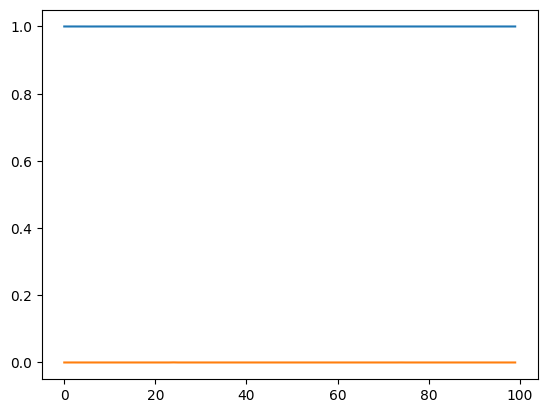

In [23]:
train_losses, val_losses = train_model(model=model, optimizer=optimizer, criterion=criterion, train_loader=train_loader, val_loader=val_loader, device=device)

import matplotlib.pyplot as plt 

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [24]:
# model.load_state_dict(torch.load("best_mlp_predictor.pth"))

In [25]:
from sklearn.metrics import r2_score

# Avaliação no conjunto de teste
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, lengths, targets in test_loader:
        inputs  = inputs.to(device)
        lengths = lengths.to(device)
        preds   = model(inputs, lengths)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds   = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

r2 = r2_score(all_targets, all_preds)
print(f"Test R²: {r2:.4f}")

/tmp/ipykernel_6110/3630557835.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return indices, len(indices), float(prop)


Test R²: -0.3387


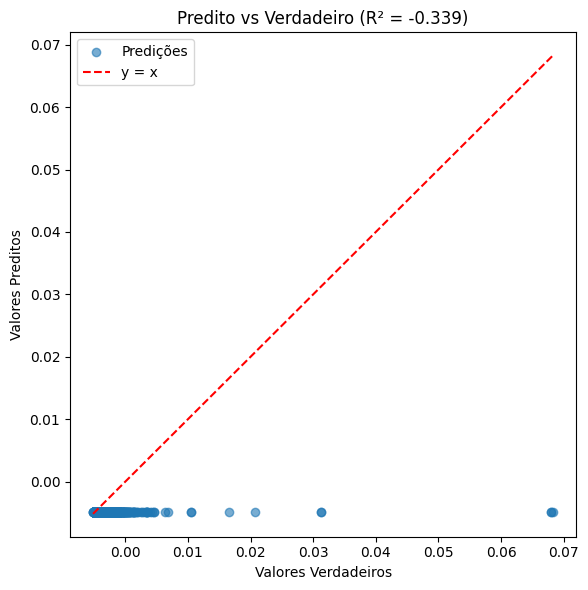

In [26]:
import matplotlib.pyplot as plt

all_targets_flat = all_targets.flatten()
all_preds_flat   = all_preds.flatten()

plt.figure(figsize=(6,6))
plt.scatter(all_targets_flat, all_preds_flat, alpha=0.6, label='Predições')
mn = min(all_targets_flat.min(), all_preds_flat.min())
mx = max(all_targets_flat.max(), all_preds_flat.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='y = x')
plt.xlabel('Valores Verdadeiros')
plt.ylabel('Valores Preditos')
plt.title(f'Predito vs Verdadeiro (R² = {r2:.3f})')
plt.legend()
plt.tight_layout()
plt.show()